In [65]:
import numpy as np 
import pandas as pd 
import sqlite3
import seaborn as sn

conn = sqlite3.connect('/kaggle/input/188-million-us-wildfires/FPA_FOD_20170508.sqlite')
#conn = sqlite3.connect('FPA_FOD_20170508.sqlite')
print("Connected to database...")

#cursor = conn.cursor()
#cursor.execute("SELECT * FROM Fires")
#rows = cursor.fetchall()
#print()
df = pd.read_sql_query("SELECT * from Fires", conn)
print("Dataframe acquired...")

conn.close()
print("Connection closed.")

Connected to database...
Dataframe acquired...
Connection closed.


# PRE-PROCESSING

In [66]:
## DATE --> DURATION
# DATE to JULIAN DATE
epoch = pd.to_datetime(0, unit='s').to_julian_date()
df.CONT_DATE = pd.to_datetime(df.CONT_DATE - epoch, unit='D')
df.DISCOVERY_DATE = pd.to_datetime(df.DISCOVERY_DATE - epoch, unit='D')
# ADD DURATION TO df
df['DURATION'] = (df.CONT_DATE - df.DISCOVERY_DATE).dt.days
print("Date conversion complete...")

## TIME TO int (really float)
df['DISCOVERY_TIME'] = pd.to_numeric(df['DISCOVERY_TIME'])
df['CONT_TIME'] = pd.to_numeric(df['CONT_TIME'])
print("Time conversion complete...")

## DROP REDUNDANT FEATURES + IDENTIFIERS
df = df.drop(['OBJECTID', 
         'FOD_ID',
         'FPA_ID',
         'SOURCE_SYSTEM_TYPE',
         'SOURCE_SYSTEM',
         'NWCG_REPORTING_AGENCY',
         'NWCG_REPORTING_UNIT_ID',
         'NWCG_REPORTING_UNIT_NAME',
         'SOURCE_REPORTING_UNIT',
         'SOURCE_REPORTING_UNIT_NAME',
         'LOCAL_FIRE_REPORT_ID',
         'LOCAL_INCIDENT_ID',
         'FIRE_CODE',
         'FIRE_NAME',
         'ICS_209_INCIDENT_NUMBER',
         'ICS_209_NAME',
         'MTBS_ID',
         'MTBS_FIRE_NAME',
         'COMPLEX_NAME',
         'DISCOVERY_DATE',
         #'DISCOVERY_TIME',
         'CONT_DATE',
         #'CONT_TIME',
         'COUNTY',
         'FIPS_CODE',
         'FIPS_NAME',
         'Shape'], axis=1)
print("Redundant features dropped...")

## REMOVE A,B,C FIRE SIZE CLASSES
df = df[df.FIRE_SIZE_CLASS.isin(['D', 'E', 'F', 'G'])]
print("A,B,C removed...")

## DROP NA
df = df.dropna()
print("Dropped fires with missing values...")

## FINAL DATAFRAME
df.FIRE_SIZE_CLASS.value_counts()

Date conversion complete...
Time conversion complete...
Redundant features dropped...
A,B,C removed...
Dropped fires with missing values...


D    14622
E     8544
F     5584
G     3151
Name: FIRE_SIZE_CLASS, dtype: int64

In [67]:
## features for decision tree + random forest:
#FIRE_YEAR             int64
#DISCOVERY_DOY         int64
#DISCOVERY_TIME      float64
#STAT_CAUSE_CODE     float64     ## EXCLUDE (dup)
#STAT_CAUSE_DESCR     object     ## ENCODE: ONE HOT
#CONT_DOY            float64
#CONT_TIME           float64
#FIRE_SIZE           float64     ## EXCLUDE (dup)
#FIRE_SIZE_CLASS      object     ## ENCODE
#LATITUDE            float64
#LONGITUDE           float64
#OWNER_CODE          float64     ## EXCLUDE (dup)
#OWNER_DESCR          object     ## ENCODE: ONE HOT
#STATE                object     ## ENCODE: ONE HOT
#DURATION            float64

df_dd = df.drop(['STAT_CAUSE_CODE',
                 'FIRE_SIZE',
                 'OWNER_CODE'], axis=1)
print("Redundant features dropped...")

Redundant features dropped...


In [68]:
def encode_one_hot(df, feature):
    cats = df[feature].unique()
    for cat in cats:
      df[cat] = (df[feature] == cat) * 1
    df = df.drop([feature], axis=1)
    return df

In [69]:
## ONE HOT ENDOCING FOR STATE, CAUSE, OWNER
df_dd = encode_one_hot(df_dd, 'STATE')
df_dd = encode_one_hot(df_dd, 'STAT_CAUSE_DESCR')
df_dd = encode_one_hot(df_dd, 'OWNER_DESCR')

In [70]:
df_dd['FIRE_SIZE_CLASS'] = pd.factorize(df['FIRE_SIZE_CLASS'])[0]
df_dd

,FIRE_YEAR,DISCOVERY_DOY,DISCOVERY_TIME,CONT_DOY,CONT_TIME,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,DURATION,CA,...,BIA,PRIVATE,STATE,FWS,BLM,NPS,BOR,COUNTY,MUNICIPAL/LOCAL,UNDEFINED FEDERAL
16,2004,280,1415.0,295.0,1000.0,0,38.523333,-120.211667,15.0,1,...,0,0,0,0,0,0,0,0,0,0
17,2004,287,1618.0,291.0,1800.0,0,38.780000,-120.260000,4.0,1,...,0,0,0,0,0,0,0,0,0,0
39,2005,43,1520.0,44.0,330.0,1,36.001667,-81.590000,1.0,0,...,0,0,0,0,0,0,0,0,0,0
116,2005,197,1715.0,198.0,1525.0,1,43.899167,-102.954722,1.0,0,...,0,0,0,0,0,0,0,0,0,0
117,2005,197,1730.0,197.0,2045.0,1,43.892778,-102.948056,0.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879800,2013,228,1639.0,240.0,800.0,2,39.443241,-121.433033,12.0,1,...,0,0,0,0,0,0,0,0,0,0
1879825,2013,232,1415.0,232.0,1602.0,1,37.724917,-121.881111,0.0,1,...,0,0,0,0,0,0,0,0,0,0
1879867,2009,15,2111.0,16.0,1448.0,1,40.463517,-124.386817,1.0,1,...,0,0,0,0,0,0,0,0,0,0
1880293,2014,157,1728.0,159.0,1800.0,3,37.600389,-120.191168,2.0,1,...,0,0,0,0,0,0,0,0,0,0


# DECISION TREE

0.4226610249177245

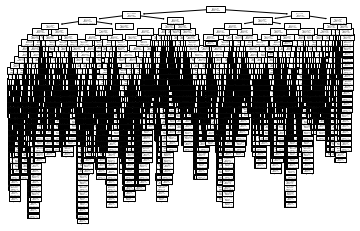

In [15]:
from sklearn.model_selection import train_test_split
from sklearn import tree

train, test = train_test_split(df_dd, test_size=0.2) 
y_train = train.FIRE_SIZE_CLASS
X_train = train.drop(['FIRE_SIZE_CLASS'], axis=1)
y_test = test.FIRE_SIZE_CLASS
X_test = test.drop(['FIRE_SIZE_CLASS'], axis=1)

## PLAY WITH PARAMETERS OF DTC:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
tree.plot_tree(dt)
dt.score(X_test,y_test)

In [86]:
stats = []

tts_ts = [0.5, 0.2, 0.1, 0.04, 0.02, 0.01]
for ts in tts_ts:
    scores = []
    for depth in range(1,30):
        train, test = train_test_split(df_dd, train_size=ts) 
        y_train = train.FIRE_SIZE_CLASS
        X_train = train.drop(['FIRE_SIZE_CLASS'], axis=1)
        y_test = test.FIRE_SIZE_CLASS
        X_test = test.drop(['FIRE_SIZE_CLASS'], axis=1)
    ## PLAY WITH PARAMETERS OF DTC:
        dt = DecisionTreeClassifier(max_depth=depth)
        dt.fit(X_train, y_train)
        #tree.plot_tree(dt)
        scores.append(dt.score(X_test,y_test))
    stats.append(scores)

Text(0, 0.5, 'decision tree accuracy')

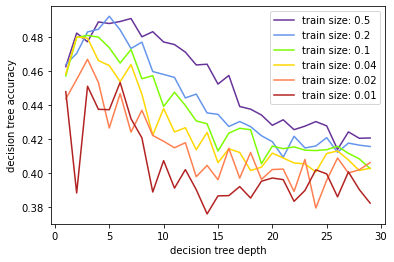

In [87]:
import matplotlib.pyplot as plt

tts_ts = [0.5, 0.2, 0.1, 0.04, 0.02, 0.01]
colors = ['rebeccapurple', 'cornflowerblue', 'lawngreen', 'gold', 'coral', 'firebrick']
depth = range(1,30)
    
for i in range(6):
    series_name = "train size: " + str(tts_ts[i])
    plt.plot(depth, stats[i], label=series_name, color=colors[i])
plt.legend()
plt.xlabel("decision tree depth")
plt.ylabel("decision tree accuracy")


Text(0, 0.5, 'decision tree accuracy')

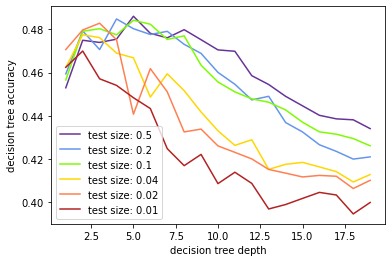

In [88]:
stats = []

tts_ts = [0.5, 0.2, 0.1, 0.04, 0.02, 0.01]
for ts in tts_ts:
    scores = []
    train, test = train_test_split(df_dd, train_size=ts) 
    y_train = train.FIRE_SIZE_CLASS
    X_train = train.drop(['FIRE_SIZE_CLASS'], axis=1)
    y_test = test.FIRE_SIZE_CLASS
    X_test = test.drop(['FIRE_SIZE_CLASS'], axis=1)
    for depth in range(1,20):
    ## PLAY WITH PARAMETERS OF DTC:
        dt = DecisionTreeClassifier(max_depth=depth)
        dt.fit(X_train, y_train)
        #tree.plot_tree(dt)
        scores.append(dt.score(X_test,y_test))
    stats.append(scores)

tts_ts = [0.5, 0.2, 0.1, 0.04, 0.02, 0.01]
colors = ['rebeccapurple', 'cornflowerblue', 'lawngreen', 'gold', 'coral', 'firebrick']
depth = range(1,20)
    
for i in range(6):
    series_name = "test size: " + str(tts_ts[i])
    plt.plot(depth, stats[i], label=series_name, color=colors[i])
plt.legend()
plt.xlabel("decision tree depth")
plt.ylabel("decision tree accuracy")

# RANDOM FORESTS

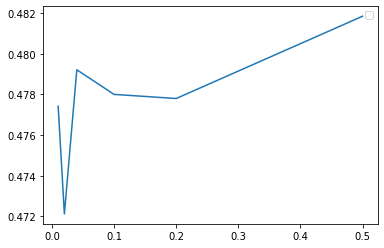

In [89]:
from sklearn.ensemble import RandomForestClassifier

scores = []

tts_ts = [0.5, 0.2, 0.1, 0.04, 0.02, 0.01]
for ts in tts_ts:
    train, test = train_test_split(df_dd, train_size=ts) 
    y_train = train.FIRE_SIZE_CLASS
    X_train = train.drop(['FIRE_SIZE_CLASS'], axis=1)
    y_test = test.FIRE_SIZE_CLASS
    X_test = test.drop(['FIRE_SIZE_CLASS'], axis=1)
    rf = RandomForestClassifier(max_depth=8, n_estimators=100)
    rf.fit(X_train, y_train)
    scores.append(rf.score(X_test,y_test))

plt.plot(tts_ts, scores)
plt.legend()

Text(0, 0.5, 'random forest accuracy')

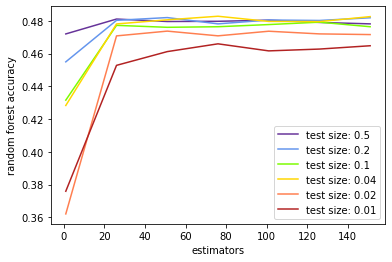

In [94]:
from sklearn.ensemble import RandomForestClassifier

stats = []

tts_ts = [0.5, 0.2, 0.1, 0.04, 0.02, 0.01]
for ts in tts_ts:
    scores = []
    train, test = train_test_split(df_dd, train_size=ts) 
    y_train = train.FIRE_SIZE_CLASS
    X_train = train.drop(['FIRE_SIZE_CLASS'], axis=1)
    y_test = test.FIRE_SIZE_CLASS
    X_test = test.drop(['FIRE_SIZE_CLASS'], axis=1)
    for est in range(1,152,25):
    ## PLAY WITH PARAMETERS OF DTC:
        rf = RandomForestClassifier(max_depth=8, n_estimators=est)
        rf.fit(X_train, y_train)
        scores.append(rf.score(X_test,y_test))
    stats.append(scores)

tts_ts = [0.5, 0.2, 0.1, 0.04, 0.02, 0.01]
colors = ['rebeccapurple', 'cornflowerblue', 'lawngreen', 'gold', 'coral', 'firebrick']
n_est = range(1,152,25)
    
for i in range(6):
    series_name = "test size: " + str(tts_ts[i])
    plt.plot(n_est, stats[i], label=series_name, color=colors[i])
plt.legend()

plt.xlabel("estimators")
plt.ylabel("random forest accuracy")